In [72]:
import sys
import os
import csv
import pandas as pd
import numpy as np
import config
import spacy
from spacy_cld import LanguageDetector
import spacy
from textblob import TextBlob
from spacy.tokens import Doc, Token
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
%matplotlib inline

plt.style.use('bmh')

In [3]:
PROJECT_PATH = config.data_directory

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
df = pd.read_csv('{}/{}.csv'.format(PROJECT_PATH, 'songs'))

In [6]:
df.describe()

,popularity,duration_ms,album_total_tracks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,50.770000,257027.058000,14.244000,0.545417,0.620193,5.252000,-10.359592,0.740000,0.062744,0.261992,0.085222,0.189449,0.520841,120.757578
std,8.392495,69327.202293,9.518701,0.171120,0.246863,3.372127,5.059964,0.439074,0.065440,0.301676,0.223874,0.152526,0.257591,30.803395
min,37.000000,85266.000000,2.000000,0.081300,0.003220,0.000000,-47.046000,0.000000,0.022400,0.000008,0.000000,0.022600,0.034500,46.718000
25%,45.000000,210983.250000,10.000000,0.416750,0.440750,2.000000,-12.581500,0.000000,0.031100,0.016600,0.000000,0.091175,0.315750,98.993750
50%,49.000000,248326.500000,12.000000,0.563000,0.662500,6.000000,-9.699000,1.000000,0.038950,0.122000,0.000057,0.129000,0.511500,115.650500
75%,56.000000,294779.750000,15.000000,0.673000,0.812250,8.000000,-7.076750,1.000000,0.058975,0.442750,0.006677,0.256250,0.728000,137.969500
max,82.000000,703133.000000,74.000000,0.980000,0.997000,11.000000,-2.410000,1.000000,0.498000,0.995000,0.956000,0.982000,0.981000,217.591000


In [7]:
df.head()

,id,name,popularity,duration_ms,explicit,artist,artist_id,album,album_id,album_release_date,...,liveness,valence,tempo,p_name,p_artist,file_name,has_lyrics,lyrics,is_english,t_entities
0,57bgtoPSgt236HzfBOd8kj,Thunderstruck,82,292880,False,AC/DC,711MCceyCBcFnzjGY4Q7Un,The Razors Edge,4vu7F6h90Br1ZtYYaqfITy,1990-09-24,...,0.2170,0.257,133.519,thunderstruck,ac dc,./data/acdc-thunderstruck.txt,True,Thunder [x10] I was caught In the middle of ...,True,"{(384, 'Beating'): 'GPE', (380, 'Thunderstruck..."
1,5pKJtX4wBeby9qIfFhyOJj,Don't Go Breaking My Heart,71,271133,False,Elton John,3PhoLpVuITZKcymswpck5b,To Be Continued...,7iKDBfOFUtg8E8RbuDhiux,1990-11-08,...,0.0685,0.779,131.312,don t go breaking my heart,elton john,./data/eltonjohn-dontgobreakingmyheart.txt,True,Don't go breaking my heart I couldn't if I t...,True,"{(383, 'Baby'): 'ORG'}"
2,6gZVQvQZOFpzIy3HblJ20F,Man in the Box,72,284426,True,Alice In Chains,64tNsm6TnZe2zpcMVMOoHL,Facelift,5LbHbwejgZXRZAgzVAjkhj,1990,...,0.2130,0.644,106.463,man in the box,alice in chains,./data/aliceinchains-maninthebox.txt,True,I'm the man in the box [Album version:] Buri...,True,"{(380, 'Jesus Christ'): 'PERSON', (383, 'Music..."
3,6m59VvDUi0UQsB2eZ9wVbH,Poison,68,261853,False,Bell Biv DeVoe,2zFZiWQJFFshzojycnXoTL,Poison,6H5mxGUWguDjtQ4Uzd8veD,1990-01-01,...,0.6120,0.803,111.848,poison,bell biv devoe,./data/bellbivdevoe-poison.txt,True,"[Michael Bivins:] Yeah, Spiderman and Freeze...",True,"{(380, 'Michael Bivins'): 'PERSON', (380, 'Spi..."
4,63vL5oxWrlvaJ0ayNaQnbX,Istanbul,73,153813,False,They Might Be Giants,6zB02lwP6L6ZH32nggQiJT,Flood,7FwAtuhhWivxvK4aPgyyUD,1990-01-02,...,0.1360,0.892,114.144,istanbul,they might be giants,./data/theymightbegiants-istanbul.txt,True,Istanbul was Constantinople Now it's Istanbu...,True,"{(384, 'Istanbul'): 'GPE', (383, 'Constantinop..."


In [8]:
Doc.set_extension('vader_negative', default=None, force=True)
Doc.set_extension('vader_neutral', default=None, force=True)
Doc.set_extension('vader_positive', default=None, force=True)
Token.set_extension('vader_negative', default=None, force=True)
Token.set_extension('vader_neutral', default=None, force=True)
Token.set_extension('vader_positive', default=None, force=True)
Doc.set_extension('tb_subjectivity', default=None, force=True)
Doc.set_extension('tb_polarity', default=None, force=True)

In [9]:
def vader_pipe(doc):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(doc.text)
    
    doc._.vader_negative = sentiment_dict['neg']
    doc._.vader_neutral = sentiment_dict['neu']
    doc._.vader_positive = sentiment_dict['pos']
    
    for sentence in doc.sents:
        for token in sentence:
            sentiment_dict_token = sid_obj.polarity_scores(token.text)
            token._.vader_negative = sentiment_dict_token['neg']
            token._.vader_neutral = sentiment_dict_token['neu']
            token._.vader_positive = sentiment_dict_token['pos']

    return doc

In [10]:
def textblob_pipe(doc):
    textBlobText = TextBlob(doc.text)
    
    doc._.tb_polarity = textBlobText.sentiment[0]
    doc._.tb_subjectivity = textBlobText.sentiment[1]

    return doc

In [11]:
if nlp.has_pipe('vader_pipe'):
    nlp.remove_pipe('vader_pipe')
nlp.add_pipe(vader_pipe)

if nlp.has_pipe('textblob_pipe'):
    nlp.remove_pipe('textblob_pipe')
nlp.add_pipe(textblob_pipe)

In [12]:
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)

In [13]:
df_eng = df[df['is_english'] == True]

In [14]:
df_eng.describe()

,popularity,duration_ms,album_total_tracks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02,256.000000,256.000000,256.000000
mean,50.742188,253495.539062,13.554688,0.546699,0.666525,5.285156,-9.635145,0.746094,0.068827,0.181146,4.799113e-02,0.186984,0.518103,124.327352
std,8.536653,60931.231195,9.172259,0.166536,0.215872,3.227446,3.535790,0.436097,0.074466,0.234661,1.489230e-01,0.138181,0.245341,29.337271
min,37.000000,115720.000000,5.000000,0.150000,0.053400,0.000000,-29.643000,0.000000,0.022400,0.000008,0.000000e+00,0.022600,0.034500,66.667000
25%,45.000000,211803.000000,10.000000,0.407000,0.504000,2.000000,-11.731250,0.000000,0.030475,0.004770,7.950000e-07,0.092200,0.322500,103.595750
50%,49.000000,246399.500000,12.000000,0.566000,0.700500,6.000000,-9.592500,1.000000,0.040950,0.065900,4.820000e-05,0.128500,0.512500,120.767500
75%,56.000000,286603.000000,14.000000,0.674500,0.840500,8.000000,-7.152500,1.000000,0.066800,0.281500,3.247500e-03,0.248250,0.701500,140.590500
max,82.000000,533306.000000,74.000000,0.980000,0.997000,11.000000,-2.410000,1.000000,0.498000,0.922000,8.530000e-01,0.820000,0.975000,217.591000


In [15]:
%%time
df_eng['nlp_lyrics'] = df_eng.apply(lambda x: nlp(x.lyrics), axis=1)

CPU times: user 25.6 s, sys: 1.21 s, total: 26.8 s
Wall time: 27.8 s


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_eng['subjectivity'] = df_eng.apply(lambda x: x.nlp_lyrics._.tb_subjectivity, axis=1)
df_eng['polarity'] = df_eng.apply(lambda x: x.nlp_lyrics._.tb_polarity, axis=1)
df_eng['subjectivity'] = df_eng.apply(lambda x: x.nlp_lyrics._.tb_subjectivity, axis=1)
df_eng['positivity'] = df_eng.apply(lambda x: x.nlp_lyrics._.vader_positive, axis=1)
df_eng['neutrality'] = df_eng.apply(lambda x: x.nlp_lyrics._.vader_neutral, axis=1)
df_eng['negativity'] = df_eng.apply(lambda x: x.nlp_lyrics._.vader_negative, axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [17]:
df_eng.sort_values(by=['negativity'], ascending=False).head()

,id,name,popularity,duration_ms,explicit,artist,artist_id,album,album_id,album_release_date,...,has_lyrics,lyrics,is_english,t_entities,nlp_lyrics,subjectivity,polarity,positivity,neutrality,negativity
457,6QKplS12OIhLVzbfCOLesv,Hell Patrol,48,216533,False,Judas Priest,2tRsMl4eGxwoNabM08Dm4I,Painkiller,7LgrhuKnAXpNEv8qzcVd2t,1990-09-26,...,True,"[Glenn Tipton, Rob Halford & K.K. Downing] ...",True,"{(380, 'Glenn Tipton'): 'PERSON', (383, 'Rob H...","( , [, Glenn, Tipton, ,, Rob, Halford, &, K.K...",0.458333,-0.172917,0.045,0.573,0.382
178,3DPyS3odFIWQ3E2IFqHEdG,Suicide Blonde,47,232009,False,INXS,1eClJfHLoDI4rZe5HxzBFv,X,688l8IJXR4cmgGj0Ekl0DR,1990,...,True,"Suicide blonde, suicide blonde Suicide blond...",True,"{(383, 'Suicide'): 'ORG', (380, 'Something'): ...","( , Suicide, blonde, ,, suicide, blonde, Suic...",0.281439,0.075473,0.176,0.471,0.353
381,1Gt07aYIpl5yJcTbH95s7v,Blood And Tears,48,259626,True,Danzig,34c4iQ5tkaZKu6Sv28BTde,Danzig II: Lucifuge,3kPaVfOEEHBDOoAbOMWvRS,1990-01-01,...,True,Blood and tears Blood and tears Since you've...,True,"{(383, 'Blood'): 'ORG', (380, 'Blood'): 'PERSO...","( , Blood, and, tears, Blood, and, tears, Sin...",0.637500,-0.181250,0.190,0.465,0.346
195,7fSOpoZTwCmS8FON3g5M4O,War Ensemble,47,291533,False,Slayer,1IQ2e1buppatiN1bxUVkrk,Seasons In The Abyss,416nVgqae48Dw0EjD6N4EU,1990-01-01,...,True,[Hanneman / Araya] Propaganda death ensembl...,True,"{(383, 'Hanneman / Araya'): 'ORG', (384, 'Stra...","( , [, Hanneman, /, Araya, ], , Propaganda, ...",0.497619,0.061905,0.050,0.607,0.343
352,02mQcDoU5cn15U6tqZmL4e,Disappear,41,250075,False,INXS,1eClJfHLoDI4rZe5HxzBFv,X,688l8IJXR4cmgGj0Ekl0DR,1990,...,True,Say I'm crying I'm looking at what's on T.V ...,True,"{(383, 'T.V Pain'): 'ORG', (383, 'Never'): 'OR...","( , Say, I, 'm, crying, I, 'm, looking, at, w...",0.568182,0.351515,0.088,0.578,0.334


In [18]:
df_eng["explicit"] = df_eng["explicit"].astype(int)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 494
Data columns (total 36 columns):
id                              256 non-null object
name                            256 non-null object
popularity                      256 non-null int64
duration_ms                     256 non-null int64
explicit                        256 non-null int64
artist                          256 non-null object
artist_id                       256 non-null object
album                           256 non-null object
album_id                        256 non-null object
album_release_date              256 non-null object
album_release_date_precision    256 non-null object
album_total_tracks              256 non-null int64
danceability                    256 non-null float64
energy                          256 non-null float64
key                             256 non-null int64
loudness                        256 non-null float64
mode                            256 non-null int64
speechiness   

In [20]:
df_eng.set_index('id')

,name,popularity,duration_ms,explicit,artist,artist_id,album,album_id,album_release_date,album_release_date_precision,...,has_lyrics,lyrics,is_english,t_entities,nlp_lyrics,subjectivity,polarity,positivity,neutrality,negativity
id,,,,,,,,,,,,,,,,,,,,,
57bgtoPSgt236HzfBOd8kj,Thunderstruck,82,292880,0,AC/DC,711MCceyCBcFnzjGY4Q7Un,The Razors Edge,4vu7F6h90Br1ZtYYaqfITy,1990-09-24,day,...,True,Thunder [x10] I was caught In the middle of ...,True,"{(384, 'Beating'): 'GPE', (380, 'Thunderstruck...","( , Thunder, [, x10, ], I, was, caught, In, t...",0.399074,0.275926,0.232,0.664,0.104
5pKJtX4wBeby9qIfFhyOJj,Don't Go Breaking My Heart,71,271133,0,Elton John,3PhoLpVuITZKcymswpck5b,To Be Continued...,7iKDBfOFUtg8E8RbuDhiux,1990-11-08,day,...,True,Don't go breaking my heart I couldn't if I t...,True,"{(383, 'Baby'): 'ORG'}","( , Do, n't, go, breaking, my, heart, I, coul...",0.563757,0.154497,0.009,0.971,0.019
6gZVQvQZOFpzIy3HblJ20F,Man in the Box,72,284426,1,Alice In Chains,64tNsm6TnZe2zpcMVMOoHL,Facelift,5LbHbwejgZXRZAgzVAjkhj,1990,year,...,True,I'm the man in the box [Album version:] Buri...,True,"{(380, 'Jesus Christ'): 'PERSON', (383, 'Music...","( , I, 'm, the, man, in, the, box, [, Album, ...",0.566667,0.058333,0.079,0.768,0.153
6m59VvDUi0UQsB2eZ9wVbH,Poison,68,261853,0,Bell Biv DeVoe,2zFZiWQJFFshzojycnXoTL,Poison,6H5mxGUWguDjtQ4Uzd8veD,1990-01-01,day,...,True,"[Michael Bivins:] Yeah, Spiderman and Freeze...",True,"{(380, 'Michael Bivins'): 'PERSON', (380, 'Spi...","( , [, Michael, Bivins, :, ], Yeah, ,, Spider...",0.613473,0.241411,0.097,0.833,0.070
63vL5oxWrlvaJ0ayNaQnbX,Istanbul,73,153813,0,They Might Be Giants,6zB02lwP6L6ZH32nggQiJT,Flood,7FwAtuhhWivxvK4aPgyyUD,1990-01-02,day,...,True,Istanbul was Constantinople Now it's Istanbu...,True,"{(384, 'Istanbul'): 'GPE', (383, 'Constantinop...","( , Istanbul, was, Constantinople, Now, it, '...",0.356566,0.152525,0.078,0.898,0.024
3Ti0GdlrotgwsAVBBugv0I,Can I Kick It?,71,251573,0,A Tribe Called Quest,09hVIj6vWgoCDtT03h8ZCa,People's Instinctive Travels and the Paths of ...,3kV0i1qqudjf0PGawJ4jck,1990-04-17,day,...,True,"[Q-Tip] Can I kick it? (Yes, you can!) [7X]...",True,"{(384, 'Quest'): 'GPE', (380, 'Gettin'): 'PERS...","( , [, Q, -, Tip, ], Can, I, kick, it, ?, , ...",0.393786,0.194229,0.168,0.802,0.030
1gVgkQFOKa8Wc1HYsJtPdH,More Than Words,70,334106,0,Extreme,6w7j5wQ5AI5OQYlcM15s2L,Extreme II - Pornograffitti,7DKHQxJTI32UyCdDdGwvRC,1990-01-01,day,...,True,Saying 'I love you' Is not the words I want ...,True,"{(383, 'Cause'): 'ORG', (397, 'two'): 'CARDINA...","( , Saying, ', I, love, you, ', Is, not, the,...",0.535101,0.408586,0.133,0.845,0.023
6NdcSEhpGGAYXNnnhGS2s6,What I Like About You,69,175400,0,The Romantics,3daM7asS0gCFvyLemNx2EE,What I Like About You (And Other Romantic Hits),5ZwUOFZdWQ81RYMwXc4j3B,1990,year,...,True,Hey Uh huh huh Hey Uh huh huh What I like a...,True,"{(384, 'Wanna'): 'GPE', (392, 'tonight'): 'TIM...","( , Hey, Uh, huh, huh, Hey, Uh, huh, huh, , ...",0.591847,0.204690,0.264,0.736,0.000
2SgbR6ttzoNlCRGQOKjrop,Cowboys From Hell,71,243533,1,Pantera,14pVkFUHDL207LzLHtSA18,Cowboys From Hell,5szY4sBOSD6IFjFN1RtWTe,1990-07-20,day,...,True,Under the lights where we stand tall Nobody ...,True,"{(381, 'Showdown'): 'NORP', (381, 'Spread'): '...","( , Under, the, lights, where, we, stand, tal...",0.443852,0.082815,0.136,0.729,0.135


In [21]:
df_eng.describe()

,popularity,duration_ms,explicit,album_total_tracks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,subjectivity,polarity,positivity,neutrality,negativity
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,50.742188,253495.539062,0.078125,13.554688,0.546699,0.666525,5.285156,-9.635145,0.746094,0.068827,0.181146,4.799113e-02,0.186984,0.518103,124.327352,0.509137,0.101441,0.137684,0.764188,0.098145
std,8.536653,60931.231195,0.268894,9.172259,0.166536,0.215872,3.227446,3.535790,0.436097,0.074466,0.234661,1.489230e-01,0.138181,0.245341,29.337271,0.123129,0.197365,0.080901,0.099042,0.078915
min,37.000000,115720.000000,0.000000,5.000000,0.150000,0.053400,0.000000,-29.643000,0.000000,0.022400,0.000008,0.000000e+00,0.022600,0.034500,66.667000,0.158333,-0.500000,0.000000,0.430000,0.000000
25%,45.000000,211803.000000,0.000000,10.000000,0.407000,0.504000,2.000000,-11.731250,0.000000,0.030475,0.004770,7.950000e-07,0.092200,0.322500,103.595750,0.431871,-0.018745,0.079000,0.702500,0.038750
50%,49.000000,246399.500000,0.000000,12.000000,0.566000,0.700500,6.000000,-9.592500,1.000000,0.040950,0.065900,4.820000e-05,0.128500,0.512500,120.767500,0.518945,0.094547,0.123000,0.774000,0.080000
75%,56.000000,286603.000000,0.000000,14.000000,0.674500,0.840500,8.000000,-7.152500,1.000000,0.066800,0.281500,3.247500e-03,0.248250,0.701500,140.590500,0.585064,0.213167,0.171250,0.830750,0.139500
max,82.000000,533306.000000,1.000000,74.000000,0.980000,0.997000,11.000000,-2.410000,1.000000,0.498000,0.922000,8.530000e-01,0.820000,0.975000,217.591000,0.900000,1.000000,0.433000,0.977000,0.382000


In [22]:
df_songs = df_eng[['name','artist','artist_id','album','album_id','file_name','has_lyrics','lyrics','t_entities','duration_ms','popularity','explicit','album_release_date','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','subjectivity','polarity','positivity','neutrality','negativity']]


In [23]:
df_songs.head(100)

,name,artist,artist_id,album,album_id,file_name,has_lyrics,lyrics,t_entities,duration_ms,...,acousticness,instrumentalness,liveness,valence,tempo,subjectivity,polarity,positivity,neutrality,negativity
0,Thunderstruck,AC/DC,711MCceyCBcFnzjGY4Q7Un,The Razors Edge,4vu7F6h90Br1ZtYYaqfITy,./data/acdc-thunderstruck.txt,True,Thunder [x10] I was caught In the middle of ...,"{(384, 'Beating'): 'GPE', (380, 'Thunderstruck...",292880,...,0.000147,0.011400,0.2170,0.2570,133.519,0.399074,0.275926,0.232,0.664,0.104
1,Don't Go Breaking My Heart,Elton John,3PhoLpVuITZKcymswpck5b,To Be Continued...,7iKDBfOFUtg8E8RbuDhiux,./data/eltonjohn-dontgobreakingmyheart.txt,True,Don't go breaking my heart I couldn't if I t...,"{(383, 'Baby'): 'ORG'}",271133,...,0.196000,0.000011,0.0685,0.7790,131.312,0.563757,0.154497,0.009,0.971,0.019
2,Man in the Box,Alice In Chains,64tNsm6TnZe2zpcMVMOoHL,Facelift,5LbHbwejgZXRZAgzVAjkhj,./data/aliceinchains-maninthebox.txt,True,I'm the man in the box [Album version:] Buri...,"{(380, 'Jesus Christ'): 'PERSON', (383, 'Music...",284426,...,0.002290,0.000008,0.2130,0.6440,106.463,0.566667,0.058333,0.079,0.768,0.153
3,Poison,Bell Biv DeVoe,2zFZiWQJFFshzojycnXoTL,Poison,6H5mxGUWguDjtQ4Uzd8veD,./data/bellbivdevoe-poison.txt,True,"[Michael Bivins:] Yeah, Spiderman and Freeze...","{(380, 'Michael Bivins'): 'PERSON', (380, 'Spi...",261853,...,0.002160,0.004320,0.6120,0.8030,111.848,0.613473,0.241411,0.097,0.833,0.070
4,Istanbul,They Might Be Giants,6zB02lwP6L6ZH32nggQiJT,Flood,7FwAtuhhWivxvK4aPgyyUD,./data/theymightbegiants-istanbul.txt,True,Istanbul was Constantinople Now it's Istanbu...,"{(384, 'Istanbul'): 'GPE', (383, 'Constantinop...",153813,...,0.080100,0.004530,0.1360,0.8920,114.144,0.356566,0.152525,0.078,0.898,0.024
5,Can I Kick It?,A Tribe Called Quest,09hVIj6vWgoCDtT03h8ZCa,People's Instinctive Travels and the Paths of ...,3kV0i1qqudjf0PGawJ4jck,./data/atribecalledquest-canikickit.txt,True,"[Q-Tip] Can I kick it? (Yes, you can!) [7X]...","{(384, 'Quest'): 'GPE', (380, 'Gettin'): 'PERS...",251573,...,0.173000,0.000699,0.1290,0.7440,96.662,0.393786,0.194229,0.168,0.802,0.030
6,More Than Words,Extreme,6w7j5wQ5AI5OQYlcM15s2L,Extreme II - Pornograffitti,7DKHQxJTI32UyCdDdGwvRC,./data/extreme-morethanwords.txt,True,Saying 'I love you' Is not the words I want ...,"{(383, 'Cause'): 'ORG', (397, 'two'): 'CARDINA...",334106,...,0.468000,0.000000,0.1140,0.2490,91.769,0.535101,0.408586,0.133,0.845,0.023
7,What I Like About You,The Romantics,3daM7asS0gCFvyLemNx2EE,What I Like About You (And Other Romantic Hits),5ZwUOFZdWQ81RYMwXc4j3B,./data/theromantics-whatilikeaboutyou.txt,True,Hey Uh huh huh Hey Uh huh huh What I like a...,"{(384, 'Wanna'): 'GPE', (392, 'tonight'): 'TIM...",175400,...,0.319000,0.000053,0.1710,0.9200,159.810,0.591847,0.204690,0.264,0.736,0.000
8,Cowboys From Hell,Pantera,14pVkFUHDL207LzLHtSA18,Cowboys From Hell,5szY4sBOSD6IFjFN1RtWTe,./data/pantera-cowboysfromhell.txt,True,Under the lights where we stand tall Nobody ...,"{(381, 'Showdown'): 'NORP', (381, 'Spread'): '...",243533,...,0.004370,0.034500,0.0820,0.4370,114.816,0.443852,0.082815,0.136,0.729,0.135
9,U Can't Touch This,MC Hammer,2rblp9fJo16ZPTcKDtlmKW,Please Hammer Don't Hurt 'Em,4r1WecJyt5FOhglysp9zhN,./data/mchammer-ucanttouchthis.txt,True,"You can't touch this [5x] My, my, my, my mu...","{(395, 'two hype feet'): 'QUANTITY', (384, 'Pu...",257360,...,0.004560,0.000339,0.0864,0.8660,133.148,0.460242,0.023053,0.069,0.881,0.050


In [24]:
df_songs.describe()

,duration_ms,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,subjectivity,polarity,positivity,neutrality,negativity
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,253495.539062,50.742188,0.078125,0.546699,0.666525,5.285156,-9.635145,0.746094,0.068827,0.181146,4.799113e-02,0.186984,0.518103,124.327352,0.509137,0.101441,0.137684,0.764188,0.098145
std,60931.231195,8.536653,0.268894,0.166536,0.215872,3.227446,3.535790,0.436097,0.074466,0.234661,1.489230e-01,0.138181,0.245341,29.337271,0.123129,0.197365,0.080901,0.099042,0.078915
min,115720.000000,37.000000,0.000000,0.150000,0.053400,0.000000,-29.643000,0.000000,0.022400,0.000008,0.000000e+00,0.022600,0.034500,66.667000,0.158333,-0.500000,0.000000,0.430000,0.000000
25%,211803.000000,45.000000,0.000000,0.407000,0.504000,2.000000,-11.731250,0.000000,0.030475,0.004770,7.950000e-07,0.092200,0.322500,103.595750,0.431871,-0.018745,0.079000,0.702500,0.038750
50%,246399.500000,49.000000,0.000000,0.566000,0.700500,6.000000,-9.592500,1.000000,0.040950,0.065900,4.820000e-05,0.128500,0.512500,120.767500,0.518945,0.094547,0.123000,0.774000,0.080000
75%,286603.000000,56.000000,0.000000,0.674500,0.840500,8.000000,-7.152500,1.000000,0.066800,0.281500,3.247500e-03,0.248250,0.701500,140.590500,0.585064,0.213167,0.171250,0.830750,0.139500
max,533306.000000,82.000000,1.000000,0.980000,0.997000,11.000000,-2.410000,1.000000,0.498000,0.922000,8.530000e-01,0.820000,0.975000,217.591000,0.900000,1.000000,0.433000,0.977000,0.382000


In [76]:
df_num = df_songs.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,duration_ms,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,subjectivity,polarity,positivity,neutrality,negativity
0,292880,82,0,0.501,0.889,4,-5.175,1,0.0364,0.000147,0.011400,0.2170,0.257,133.519,0.399074,0.275926,0.232,0.664,0.104
1,271133,71,0,0.743,0.858,5,-7.790,1,0.0416,0.196000,0.000011,0.0685,0.779,131.312,0.563757,0.154497,0.009,0.971,0.019
2,284426,72,1,0.346,0.765,8,-8.558,1,0.0413,0.002290,0.000008,0.2130,0.644,106.463,0.566667,0.058333,0.079,0.768,0.153
3,261853,68,0,0.829,0.573,6,-10.316,0,0.2240,0.002160,0.004320,0.6120,0.803,111.848,0.613473,0.241411,0.097,0.833,0.070
4,153813,73,0,0.688,0.748,5,-9.390,0,0.0377,0.080100,0.004530,0.1360,0.892,114.144,0.356566,0.152525,0.078,0.898,0.024


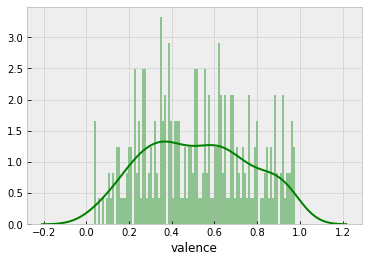

In [41]:
sns.distplot(df_songs['valence'], color='g', bins=100, hist_kws={'alpha': 0.4});

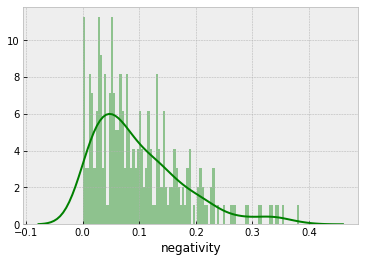

In [42]:
sns.distplot(df_songs['negativity'], color='g', bins=100, hist_kws={'alpha': 0.4});

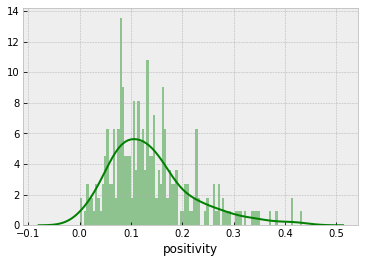

In [43]:
sns.distplot(df_songs['positivity'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [44]:
df_songs.corr()

,duration_ms,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,subjectivity,polarity,positivity,neutrality,negativity
duration_ms,1.000000,0.032764,0.077947,-0.162465,0.074518,0.015815,0.058494,-0.086140,0.198184,-0.151111,-0.065076,-0.101270,-0.260079,0.041493,0.036395,-0.038922,0.015348,-0.130642,0.148355
popularity,0.032764,1.000000,0.044686,0.072680,0.087579,-0.062369,0.104348,0.048711,0.028405,-0.065227,-0.026551,0.006165,0.047891,-0.109730,-0.024661,0.053144,0.011783,0.098958,-0.135927
explicit,0.077947,0.044686,1.000000,-0.084507,0.156838,-0.003177,-0.069889,-0.097714,0.229254,-0.197433,0.257877,0.120997,-0.115319,-0.029937,-0.018476,-0.180184,-0.143257,-0.078301,0.245259
danceability,-0.162465,0.072680,-0.084507,1.000000,-0.149314,-0.026011,-0.104715,-0.043875,0.151088,0.119950,-0.084241,0.093750,0.548752,-0.229465,-0.031965,0.096942,-0.079097,0.222194,-0.198029
energy,0.074518,0.087579,0.156838,-0.149314,1.000000,0.035755,0.747586,-0.104069,0.203439,-0.651653,0.176161,0.021236,0.175137,0.118884,-0.089010,-0.210846,-0.157389,-0.110253,0.299688
key,0.015815,-0.062369,-0.003177,-0.026011,0.035755,1.000000,0.034037,-0.096027,-0.016933,-0.019112,0.020314,-0.014997,-0.072972,0.061994,-0.054679,-0.012271,-0.144199,0.101965,0.019977
loudness,0.058494,0.104348,-0.069889,-0.104715,0.747586,0.034037,1.000000,0.120999,0.040040,-0.484829,0.008669,-0.023383,0.068916,0.072112,-0.035840,-0.061939,-0.011170,-0.191904,0.251887
mode,-0.086140,0.048711,-0.097714,-0.043875,-0.104069,-0.096027,0.120999,1.000000,-0.230028,0.090672,-0.131818,0.065187,-0.065767,-0.026942,-0.055853,0.024009,0.135989,-0.043836,-0.084734
speechiness,0.198184,0.028405,0.229254,0.151088,0.203439,-0.016933,0.040040,-0.230028,1.000000,-0.232438,-0.030889,0.232348,-0.031190,0.113796,0.005640,-0.123062,-0.122774,-0.024888,0.157427
acousticness,-0.151111,-0.065227,-0.197433,0.119950,-0.651653,-0.019112,-0.484829,0.090672,-0.232438,1.000000,-0.116945,0.021470,-0.012805,-0.104784,-0.052790,0.169437,0.109887,0.133197,-0.280087


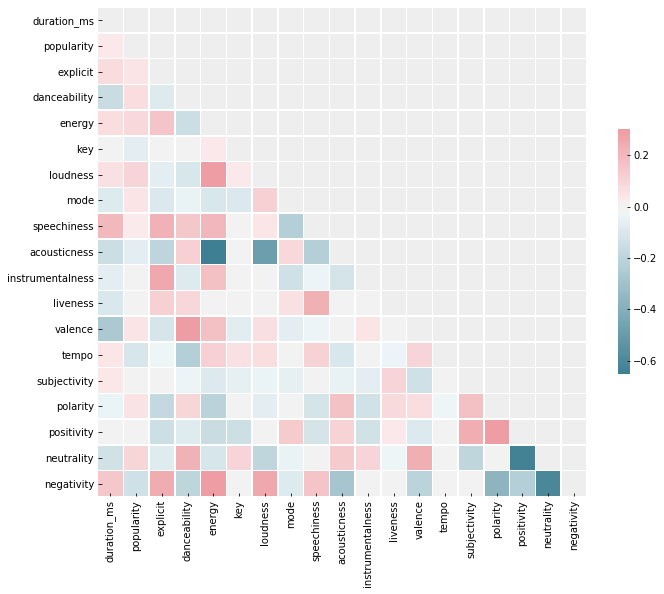

In [39]:
# Compute the correlation matrix
corr = df_songs.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

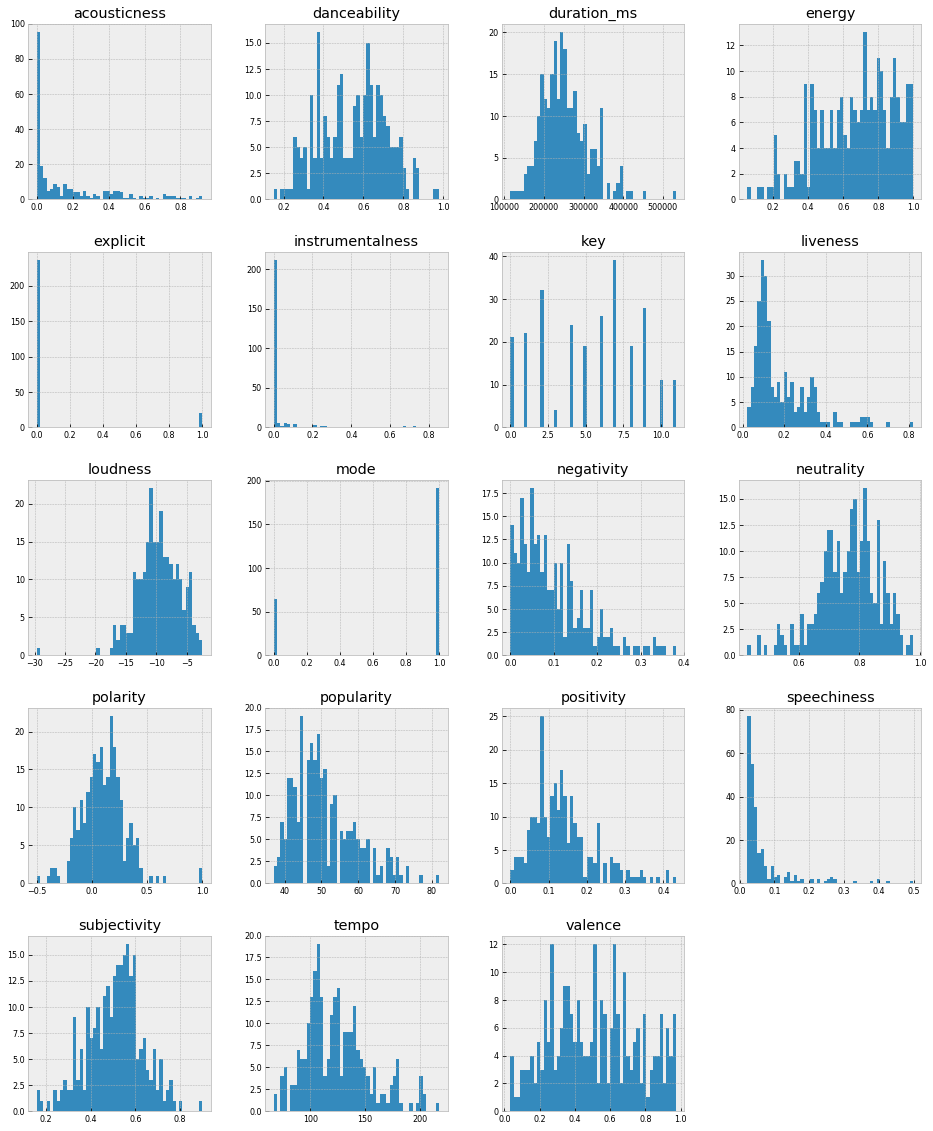

In [45]:
df_songs.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


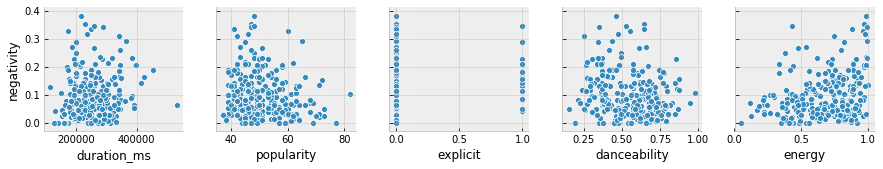

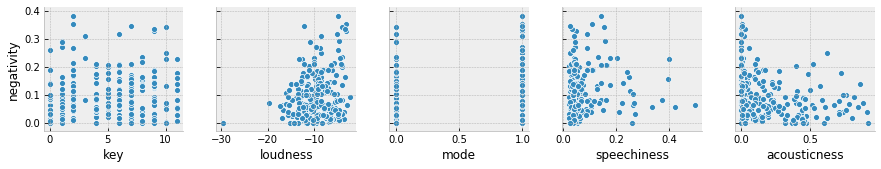

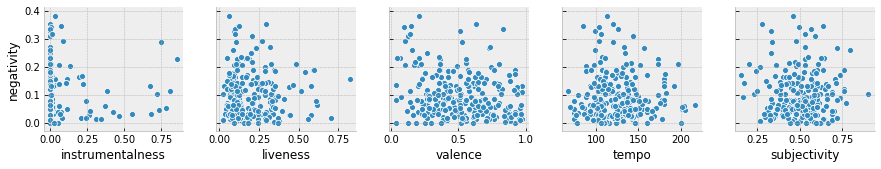

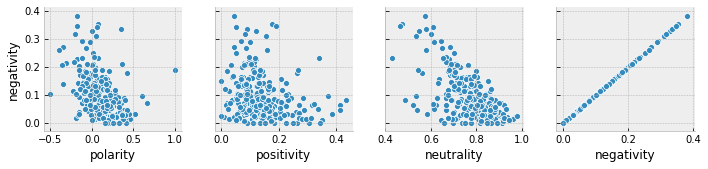

In [46]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['negativity'])

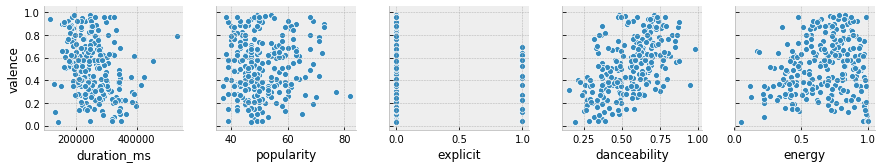

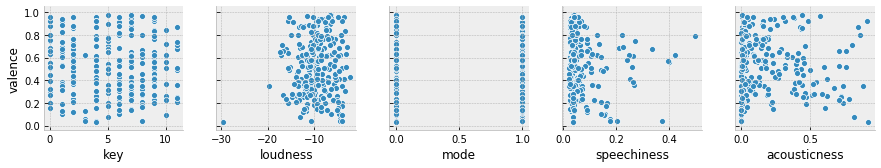

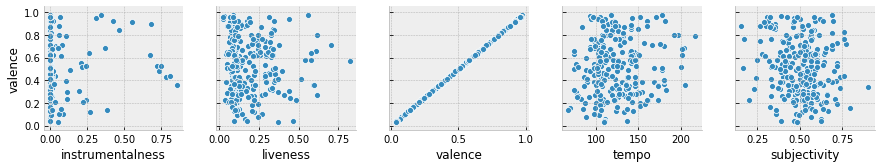

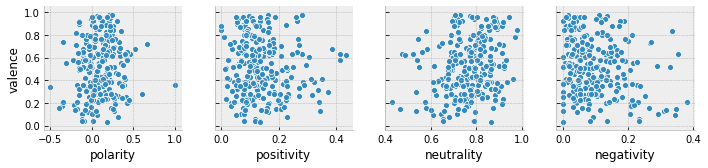

In [47]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['valence'])

In [82]:
model = KMeans(n_clusters=3)

X = preprocessing.normalize(df_num, norm='l2')

model.fit(X)
y_kmeans = model.predict(X)


In [83]:
y_kmeans

array([2, 2, 0, 0, 1, 0, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 1, 0, 2, 0,
       0, 2, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0,
       2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1,
       0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0,
       2, 2, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1, 2, 2, 0, 2, 2, 2, 0, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0,
       1, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 1], dtype=int32)

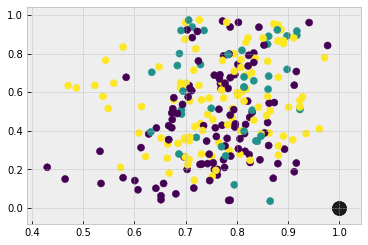

In [84]:
plt.scatter(df_num['neutrality'], df_num['valence'], c=y_kmeans, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [85]:
model.cluster_centers_

array([[ 9.99999913e-01,  1.76099722e-04,  3.47980020e-07,
         1.92681631e-06,  2.25855064e-06,  1.77756137e-05,
        -3.41859615e-05,  2.44454732e-06,  2.58222786e-07,
         6.54142245e-07,  1.75932519e-07,  6.42877295e-07,
         1.59129875e-06,  3.68506020e-04,  1.80831773e-06,
         3.55247147e-07,  4.91648879e-07,  2.63498582e-06,
         3.55311518e-07],
       [ 9.99999601e-01,  2.73585289e-04,  1.83219875e-07,
         2.75877183e-06,  3.53594607e-06,  2.92679199e-05,
        -5.81307130e-05,  3.61084758e-06,  3.86823212e-07,
         1.11320591e-06,  3.60371122e-07,  1.11477771e-06,
         3.33421453e-06,  8.37670406e-04,  2.83003693e-06,
         5.33308625e-07,  7.60701581e-07,  4.31840433e-06,
         3.93769379e-07],
       [ 9.99999821e-01,  2.22511256e-04,  3.16942488e-07,
         2.49719854e-06,  2.96621613e-06,  2.36516580e-05,
        -4.01706831e-05,  3.64829611e-06,  2.55124286e-07,
         8.04135388e-07,  1.83361016e-07,  8.22638068e-07,
    